In [1]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import SystemMessage, ToolMessage, BaseMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
# !pip install langchain_tavily
#pip install python-dotenv

/home/ali/AI/10.LangGraph/venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/home/ali/AI/10.LangGraph/venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [2]:
load_dotenv(override=True)

True

In [6]:
tavily = TavilySearch(max_results=2)

In [7]:
result = tavily.invoke("Who won the psl match in lahore pakistan in 2025")

In [8]:
print(result)

{'query': 'Who won the psl match in lahore pakistan in 2025', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.facebook.com/groups/370174241257772/posts/1243119233963264/', 'title': 'Lahore Qalandars win Pakistan Super League 2025 final - Facebook', 'content': 'Lahore Qalandars beat Quetta Gladiators by six wickets to win the Pakistan Super League (PSL) 2025 at the Gaddafi Stadium in Lahore, Pakistan.', 'score': 0.9999473, 'raw_content': None}, {'url': 'https://en.wikipedia.org/wiki/2025_Pakistan_Super_League_final', 'title': '2025 Pakistan Super League final - Wikipedia', 'content': '| Player of the match "Player of the Match awards (cricket)") | Kusal Perera (Lahore Qalandars) |. The **2025 Pakistan Super League final** was a Twenty20 cricket match played between Lahore Qalandars and Quetta Gladiators to decide the champion of the 2025 season of the Pakistan Super League (PSL) on 25 May 2025 at the Gaddafi Stadium in Lahore, Pakistan. Lahore

In [15]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [16]:
@tool
def google_search(query: str):
    """This function is used to do the google search"""
    result = tavily.invoke(query)
    return result

In [17]:
@tool
def add(num1: int, num2: int):
    """This function add two numbers together"""
    sum = num1 + num2
    return sum

In [18]:
@tool
def multiply(num1: int, num2: int):
    """This function multiply tow numbers together"""
    multiply = num1 * num2
    return multiply

In [19]:
tools = [add, multiply, google_search]

In [20]:
llm = ChatOllama(model = 'qwen2.5').bind_tools(tools)

In [21]:
def llm_node(state: AgentState) -> AgentState:
    print("\n\nSTATE: ", state)
    system_prompt = SystemMessage(["You are helfull assistant that answers the user's question accurately."])
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [22]:
def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "tool_call"

In [23]:
graph = StateGraph(AgentState)
graph.add_node("llm", llm_node)

tool_node = ToolNode(tools = tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("llm")
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        "tool_call": "tools",
        "end": END
    }
)

graph.add_edge("tools", "llm")
agent = graph.compile()

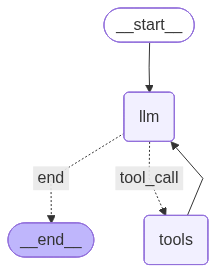

In [24]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [25]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [26]:
inputs = {"messages": [("user", "Who won the psl match of cricket in lahore pakistan in 2025")]}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Who won the psl match of cricket in lahore pakistan in 2025


STATE:  {'messages': [HumanMessage(content='Who won the psl match of cricket in lahore pakistan in 2025', additional_kwargs={}, response_metadata={}, id='b7ca9394-cc92-4767-badd-9299429cb500')]}
================================== Ai Message ==================================
Tool Calls:
  google_search (233b26ce-88ca-4ae5-9120-5766aa27bc43)
 Call ID: 233b26ce-88ca-4ae5-9120-5766aa27bc43
  Args:
    query: PSL cricket match winner in Lahore Pakistan 2025
================================= Tool Message =================================
Name: google_search

{"query": "PSL cricket match winner in Lahore Pakistan 2025", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.facebook.com/groups/1101279801269006/posts/1714655719931408/", "title": "Lahore Qalandars win PSL 2025 final by 8 wickets - Facebook", "conten